<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Mini-Case_Part1_Price-Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8: Retail analytics - Mini-Case
---
*Yossiri Adulyasak*

---

# Part 1: Initial analyses on demand-price relationships

This is the full version of the Module 1 (predictive model) for session 8 which extend the simplified version of one item to multiple items.

We begin by loading the required packages.

In [1]:
import pandas as pd  # Library for data manipulation (DataFrames)
import numpy as np   # Library for numerical operations (needed for square roots, etc.)

# Import specific machine learning models
import xgboost as xgb        # XGBoost: Optimized Gradient Boosting library
import lightgbm as lgb       # LightGBM: Another high-performance Gradient Boosting library
from sklearn.linear_model import LinearRegression  # Basic Linear Regression
from sklearn.ensemble import RandomForestRegressor # Random Forest (ensemble of trees)

# Import metrics to measure how "wrong" our predictions are
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error



Data input

In [3]:
# -------------------------------------------------------------------------
# LOAD AND PREPARE DATA
# -------------------------------------------------------------------------
URL = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/S08_09_Retail_Analytics/data/cereals_data_full.csv'
df = pd.read_csv(URL)
# Drop any rows that have missing values (NaN).
df = df.dropna()

# Calculate the discount column from 'BASE_PRICE' and 'PRICE'
df['DISCOUNT'] = (df['BASE_PRICE'] - df['PRICE']) / df['BASE_PRICE']

# Convert the 'WEEK_END_DATE' column from string format to a datetime object. This allows us to sort the data chronologically.
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

# Extract Week Number (1-53) to capture seasonality
df['WEEK_NUM'] = df['WEEK_END_DATE'].dt.isocalendar().week.astype(int)

# Sort the dataset by date. This is CRITICAL for time-series splits as we want to train on the "past" and test on the "future".
df = df.sort_values('WEEK_END_DATE')
df

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE,DISCOUNT,WEEK_NUM
0,2009-01-14,367,1111085319,14,13,13,26.32,1.88,1.88,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.000000,3
457,2009-01-14,21213,3800039118,32,31,31,86.08,2.69,3.32,1,1,0,KELLOGG,COLD CEREAL,KIDS CEREAL,12 OZ,0.189759,3
458,2009-01-14,21221,1111085319,15,13,13,28.20,1.88,1.88,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.000000,3
459,2009-01-14,21221,1111085345,35,30,29,65.45,1.87,1.87,0,0,0,PRIVATE LABEL,COLD CEREAL,ADULT CEREAL,18 OZ,0.000000,3
460,2009-01-14,21221,1111085350,71,53,52,139.16,1.96,1.96,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,18 OZ,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138178,2012-01-04,10019,1111085345,17,12,12,27.54,1.62,1.62,0,0,0,PRIVATE LABEL,COLD CEREAL,ADULT CEREAL,18 OZ,0.000000,1
138179,2012-01-04,10019,1111085350,4,3,3,8.88,2.22,2.22,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,18 OZ,0.000000,1
138180,2012-01-04,10019,1600027527,82,71,71,163.18,1.99,2.68,0,0,1,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.257463,1
138182,2012-01-04,10019,1600027564,17,16,16,51.34,3.02,3.02,0,0,0,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.000000,1


# Initial analyses on demand-price relationships

Select 3-4 unique combinations of 'STORE_NUM' and 'UPC' from the DataFrame `df` to use for plotting.


In [36]:
import numpy as np

sampled_combinations_list = [(25229, 1600027528), (25027, 88491201427), (21221, 3800031838), (4259, 88491201427)]

print(f"Selected {len(sampled_combinations_list)} unique Store-UPC combinations:")
print(sampled_combinations_list)


Selected 4 unique Store-UPC combinations:
[(25229, 1600027528), (25027, 88491201427), (21221, 3800031838), (4259, 88491201427)]


### Demand-price curves

We now create the demand-price plots for each of these combinations. This involves filtering the DataFrame for each combination and plotting both the original and log-transformed price-unit relationships in subplots.




[(25229, 1600027528), (25027, 88491201427), (21221, 3800031838), (4259, 88491201427)]


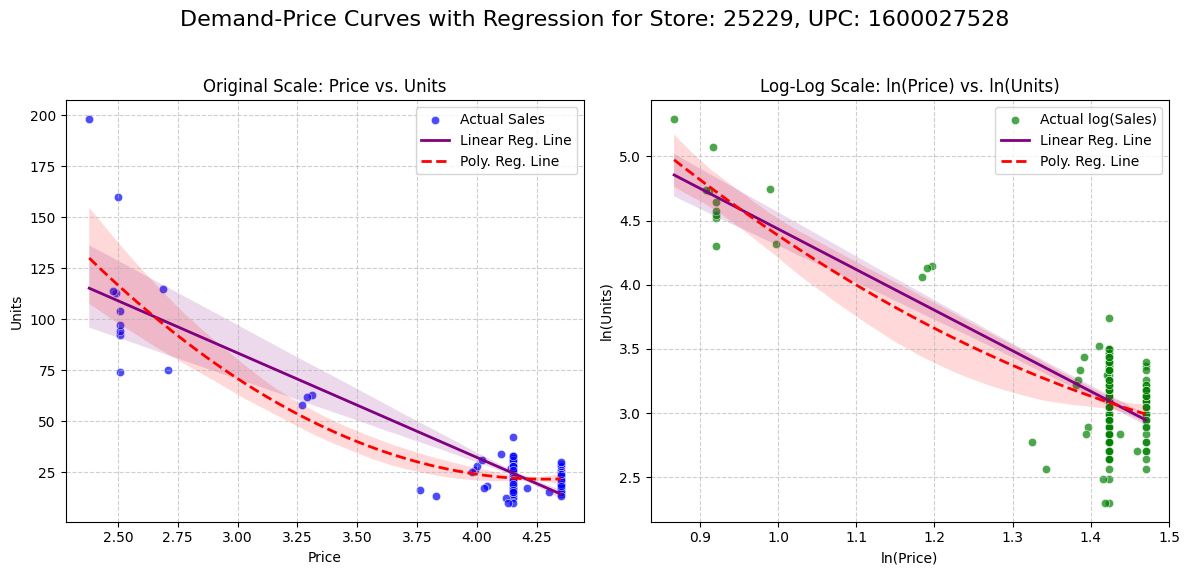

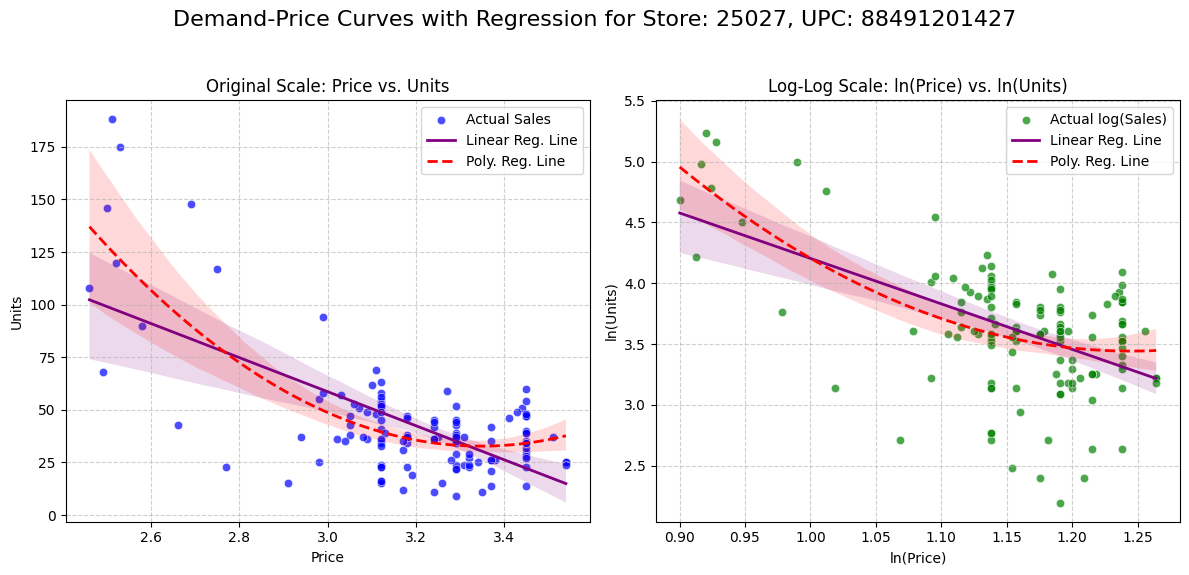

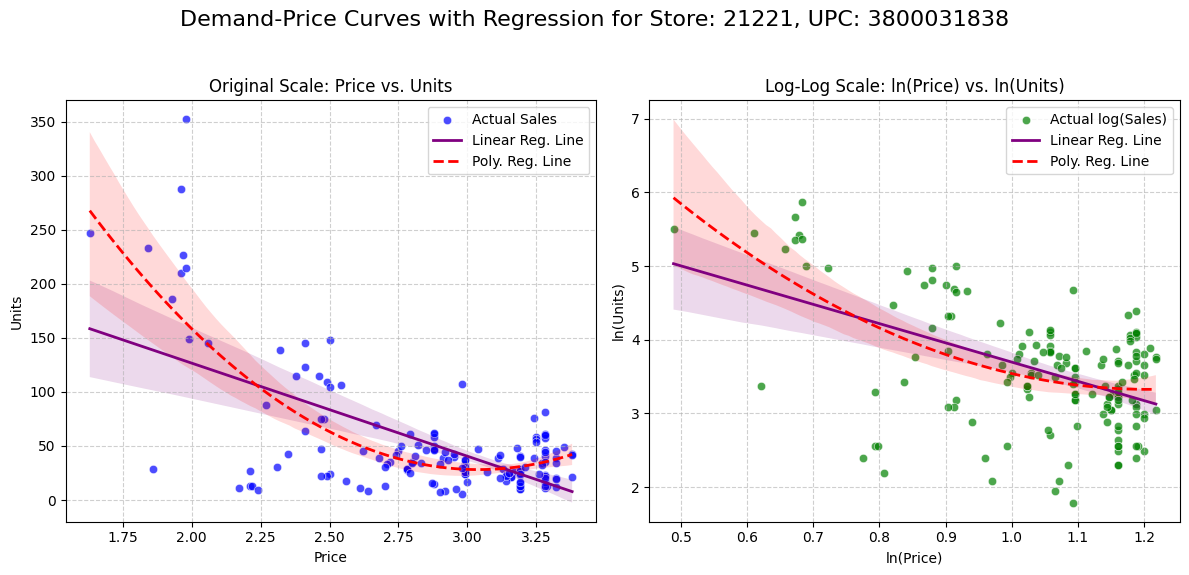

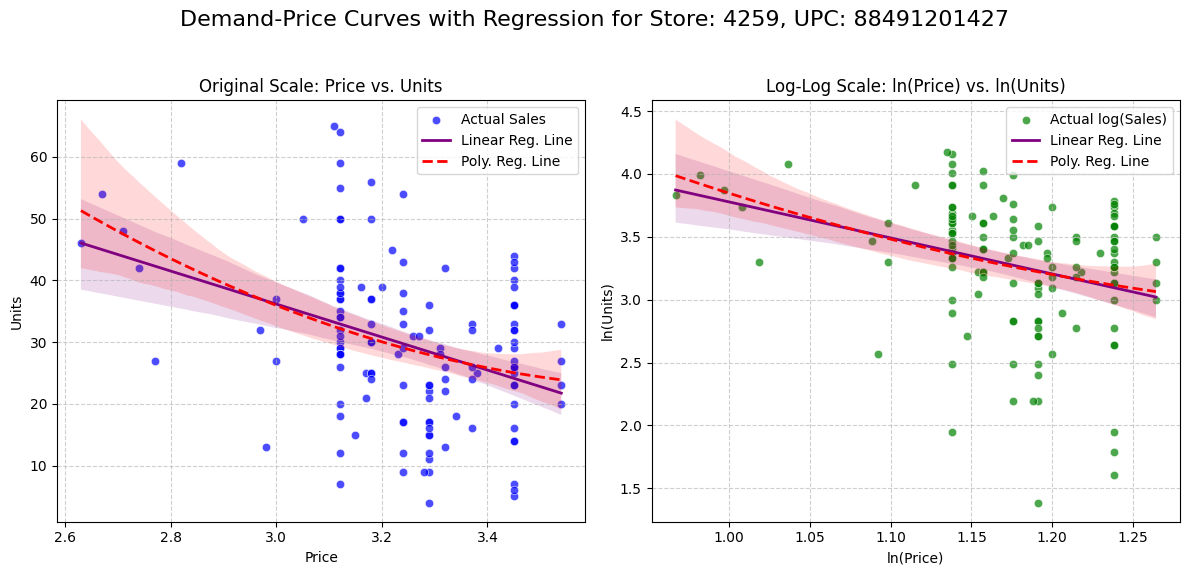

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

print(sampled_combinations_list)

# Create demand-price plots for each sampled combination
for store_num, upc_num in sampled_combinations_list:
    # Filter the DataFrame for the current Store-UPC combination
    subset_df = df[(df['STORE_NUM'] == store_num) & (df['UPC'] == upc_num)].copy()

    # Drop rows with NaN values in ln_UNITS or ln_PRICE for plotting consistency
    subset_df.dropna(subset=['ln_UNITS', 'ln_PRICE'], inplace=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Demand-Price Curves with Regression for Store: {store_num}, UPC: {upc_num}', fontsize=16)

    # Plot 1: Price vs. Units (Original Scale) with Polynomial Regression
    sns.scatterplot(data=subset_df, x='PRICE', y='UNITS', ax=axes[0], alpha=0.7, color='blue', label='Actual Sales')
    sns.regplot(data=subset_df, x='PRICE', y='UNITS', ax=axes[0], scatter=False, color='purple', line_kws={'linestyle':'-', 'linewidth':2}, order=1, label='Linear Reg. Line')
    sns.regplot(data=subset_df, x='PRICE', y='UNITS', ax=axes[0], scatter=False, color='red', line_kws={'linestyle':'--', 'linewidth':2}, order=2, label='Poly. Reg. Line')
    axes[0].set_title('Original Scale: Price vs. Units')
    axes[0].set_xlabel('Price')
    axes[0].set_ylabel('Units')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Plot 2: ln_PRICE vs. ln_UNITS (Log-Log Scale) with Linear Regression
    sns.scatterplot(data=subset_df, x='ln_PRICE', y='ln_UNITS', ax=axes[1], alpha=0.7, color='green', label='Actual log(Sales)')
    sns.regplot(data=subset_df, x='ln_PRICE', y='ln_UNITS', ax=axes[1], scatter=False, color='purple', line_kws={'linestyle':'-', 'linewidth':2}, order=1, label='Linear Reg. Line')
    sns.regplot(data=subset_df, x='ln_PRICE', y='ln_UNITS', ax=axes[1], scatter=False, color='red', line_kws={'linestyle':'--', 'linewidth':2}, order=2, label='Poly. Reg. Line')
    axes[1].set_title('Log-Log Scale: ln(Price) vs. ln(Units)')
    axes[1].set_xlabel('ln(Price)')
    axes[1].set_ylabel('ln(Units)')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


### Correlation Matrix and Heatmap Visualization

Calculate the correlation matrix for `ln_PRICE`, `FEATURE`, `DISPLAY`, and `ln_UNITS` and visualize it using a heatmap with a legend. This will help understand the linear relationships between these key variables, especially how log-transformed price, feature status, and display status correlate with log-transformed units.



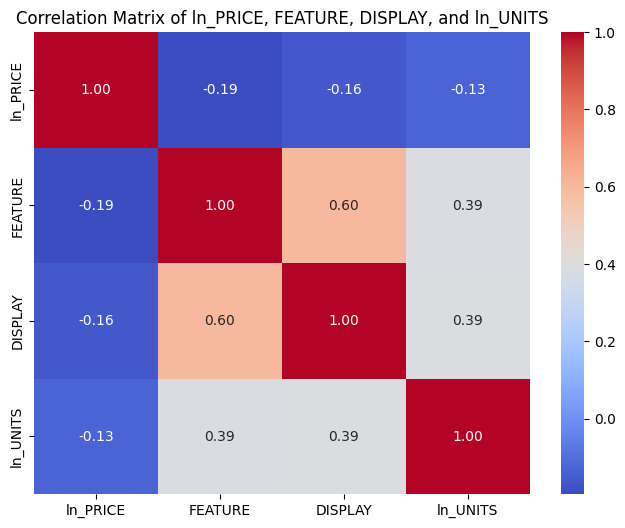

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for the correlation matrix
correlation_cols = ['ln_PRICE', 'FEATURE', 'DISPLAY', 'ln_UNITS']
correlation_df = df[correlation_cols]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Create a heatmap using `seaborn.heatmap()`, ensuring to add annotations (`annot=True`) for better readability and a color bar (`cbar=True`) as a legend.
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix of ln_PRICE, FEATURE, DISPLAY, and ln_UNITS')
plt.show()

### Summary of Observations

**Price vs. Units Scatter Plot:**
The scatter plot of 'PRICE' vs. 'UNITS' visually suggests an inverse relationship, forming a downward-sloping. This is consistent with a basic demand curve, where higher prices generally correspond to lower sales units. The spread of the data indicates that while a general trend exists, other factors (like promotions, store, and product characteristics) also potentially  influence units sold.

**Log-log Transformation:**
The log-log transformation (`ln_UNITS` and `ln_PRICE`) was applied. This transformation is crucial for demand modeling because it linearizes multiplicative relationships, making them easier to model with linear regression and allowing for direct interpretation of coefficients as elasticities. For instance, the coefficient of `ln_PRICE` when predicting `ln_UNITS` can be interpreted as the price elasticity of demand.

**Correlation Matrix and Heatmap:**
The heatmap of the correlation matrix for `ln_PRICE`, `FEATURE`, `DISPLAY`, and `ln_UNITS` provides quantitative insights:
*   **`ln_PRICE` vs. `ln_UNITS`**: A negative correlation (-0.13) confirms the inverse relationship observed in the scatter plot. While not extremely strong, it's statistically significant and in the expected direction.
*   **`FEATURE` vs. `ln_UNITS`**: A positive correlation (0.39) indicates that when a product is 'FEATURED', units sold tend to be higher. This is a strong positive relationship.
*   **`DISPLAY` vs. `ln_UNITS`**: Similarly, a positive correlation (0.39) suggests that products on 'DISPLAY' also tend to have higher units sold, with a similar strength to the 'FEATURE' effect.
*   **`FEATURE` vs. `DISPLAY`**: There's a notable positive correlation (0.60) between 'FEATURE' and 'DISPLAY', suggesting that products that are featured are often also placed on display, and vice-versa.

**Conclusion on Predictor Variables:**
The analysis confirms that `ln_PRICE`, `FEATURE`, and `DISPLAY` are indeed key predictor variables for `ln_UNITS`. The log-log transformation of price and units is appropriate for modeling price elasticity, and both `FEATURE` and `DISPLAY` show meaningful positive correlations with units sold, indicating their importance in driving demand. These variables are well-suited for inclusion in a predictive demand model.